In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install -r https://raw.githubusercontent.com/abbbe/eye-on-stick/main/requirements.txt
    !git clone https://github.com/abbbe/eye-on-stick
    %cd eye-on-stick

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import os, urllib, time
os.environ["MLFLOW_TRACKING_URI"] = "sqlite:///mlruns/db.sqlite"
import mlflow, git
mlflow_client = mlflow.tracking.MlflowClient()

from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines import PPO2, SAC

import matplotlib.pyplot as plt
%matplotlib inline
from lib.viz import showarray
from IPython import display

from lib import eos
from lib.eos import EyeOnStickEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
with git.Repo() as repo:
    git_info = f'{repo.active_branch.name}/{repo.git.rev_parse(repo.head.object.hexsha, short=4)}'
    if repo.is_dirty():
        git_info = f'*{git_info}'

In [4]:
import json
from lib.run import run_env_nsteps

def log_metrics(metrics, step):
    # log the content of metrics dict as mlflow metrics
    for key, value in metrics.items():
        mlflow.log_metric(key=key, value=value, step=step)

def save_and_register_model(model, params, saved_models_dir, era, model_name, mlflow_run):    
    # save the trained models, each era separately
    model_fname = f'{saved_models_dir}/{era}'
    model.save(model_fname)

    params_fname = f'{saved_models_dir}/{era}.json'

    with open(params_fname, 'w') as fp:
        json.dump(params, fp)
    
    # register the trained model
    return mlflow_client.create_model_version(name=model_name, source=model_fname, run_id=mlflow_run.info.run_id)

In [5]:
def learn_and_run(n_joints, n_eras, n_learn_episodes, params, gym_policy_class=SAC, gym_model_name='MlpPolicy', name=None, displayfunc=None, start_version=None):
    """
    1. Instanciates environment with n_joints.
    2. Train the model for N_LEARN_EPOCHS epochs.
    3. Save the model as mlflow artefact, named by 'name'.
    2. Step through the environment for N_ERAS x N_STEPS steps, collecting metrics and rendering it (if 'display' is set).
    3. Log metrics into mlflow runs (parent run gets '{n_joints}J {name}' name).
    7. Returns file name to load the model from.
    """
    env = make_vec_env(lambda: EyeOnStickEnv(n_joints, params), n_envs=N_ENVS)
    #env = VecNormalize(env)

    n_steps = params.get('MAX_NSTEPS')
    run_name = f'eos.{n_joints}J'
    model_name = run_name
    if name is not None:
        run_name += f' {name}'

    # create new mlflow run which will become a parent of per-era runs
    with mlflow.start_run(run_name=run_name) as parent_run:
        # log gym  params
        mlflow.log_param("gym_policy_class", gym_policy_class.__name__)
        mlflow.log_param("gym_model_name", gym_model_name)
        mlflow.log_param("start_version", start_version)
        for key, value in params.items():
            mlflow.log_param(key, value)

        # arrange tensorboard logs
        mlflow_artifacts_dir = urllib.request.url2pathname(urllib.parse.urlparse(mlflow.get_artifact_uri()).path)
        tensorboard_logdir = os.path.join(mlflow_artifacts_dir, "tensorboard_log")
        os.makedirs(tensorboard_logdir, exist_ok=False)

        # create gym model and directory to save it
        if start_version:
            registered_model = mlflow_client.get_model_version(model_name, start_version)
            model = gym_policy_class.load(registered_model.source)
            model.set_env(env)
        else:
            model = gym_policy_class(gym_model_name, env, verbose=0, tensorboard_log=tensorboard_logdir)
            
        saved_models_dir = os.path.join(mlflow_artifacts_dir, "saved_models")
        os.makedirs(saved_models_dir, exist_ok=False)

        ## run eras loop
        metrics = None
        for era in range(n_eras):
            child_run_name = f'era={era}'
            
            with mlflow.start_run(run_name=child_run_name, nested=True) as child_run:            
                model.learn(n_learn_episodes * n_steps)
                registered_model = save_and_register_model(model, params, saved_models_dir, era, model_name, child_run)
                mlflow.log_metric("model_version", registered_model.version)

                env.env_method('set_render_info', {'model_name': registered_model.name, 'model_version': registered_model.version, 'start_version': start_version})
                metrics, _data = run_env_nsteps(env, model, n_steps, displayfunc=displayfunc)
                log_metrics(metrics, step=era)
                    
        # log to the parent run
        if metrics:
            log_metrics(metrics, step=None)
            
    env.close()

In [6]:
# we run N_ERAS eras (=mlflow runs) in total:
#   first we let the agent learn for N_LEARN_EPISODES * MAX_NSTEPS
#   then we run it one episode and log metrics
N_ERAS = 25 # eras 
N_LEARN_EPISODES = 100
MAX_NSTEPS = 150 # episode will end after so many steps
N_ENVS = 1

In [7]:
NJ = 3

In [8]:
# SAC(policy, env, gamma=0.99, learning_rate=0.0003, buffer_size=50000, learning_starts=100, train_freq=1,
# batch_size=64, tau=0.005, ent_coef='auto', target_update_interval=1, gradient_steps=1, target_entropy='auto', action_noise=None,
# random_exploration=0.0, verbose=0, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None, n_cpu_tf_sess=None)

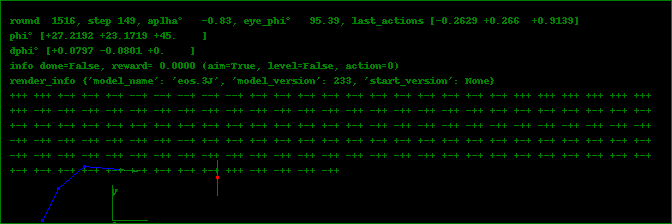

-----------------------------------------
| current_lr              | 0.0003      |
| ent_coef                | 0.018612795 |
| ent_coef_loss           | -3.215201   |
| entropy                 | 1.6376001   |
| ep_rewmean              | 46.3        |
| episodes                | 4           |
| eplenmean               | 151         |
| fps                     | 455         |
| mean 100 episode reward | 5           |
| n_updates               | 354         |
| policy_loss             | -14.068381  |
| qf1_loss                | 0.40191776  |
| qf2_loss                | 0.37016225  |
| time_elapsed            | 0           |
| total timesteps         | 453         |
| value_loss              | 0.24991703  |
-----------------------------------------


In [ ]:
for _ in range(10):
    learn_and_run(
        n_joints=NJ,
        n_eras=N_ERAS, n_learn_episodes=N_LEARN_EPISODES,
        params={'MAX_NSTEPS': MAX_NSTEPS, 'ALPHA_MAXDIFF_GOAL': 3, 'EYE_PHI_MAXDIFF_GOAL': 3},
        name='no eye_phi obs', displayfunc=True)